# Youtube 數據分析
* Joeman，木曜4超玩，志祺七七 X 圖文不符，Dcard Video，Men's Game 玩物誌


訂閱數高不代表觀看率高，訂閱數和轉換率也沒有絕對的正相關。

## 目錄
* 專案概述
* 資料來源
* 工具使用
* 商業問題
* 資料探索及清洗
* 資料分析
* 儀表板建立
* 結論
* 建議
* 限制說明
* 其他想法
* 參考資料

## 載入 YOUTUBE API KEY

[YouTube Data API (v3) - Quota](https://developers.google.com/youtube/v3/determine_quota_cost)

The quota cost for calling each API method. All API requests, including invalid requests, incur a quota cost of at least one point.

The following point are worth calling out as they both affect your quota usage:
* If your application calls a method, such as search.list, that returns multiple pages of results, each request to retrieve an additional page of results incurs the estimated quota cost.

Google Cloud API Quota 歸零時間是每天下午3點<br>
Queries per day limitation：10,000

In [ ]:
# 連接雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# 環境變數文件的路徑
env_file_path = '/content/drive/MyDrive/Colab Notebooks/env_var/api_key.ipynb'

# 将環境變數文件导入到目前的Colab文件中
%run "$env_file_path"

# 使用加载進來的環境變數獲得 YOUTUBE API KEY
api_key = os.environ.get('YOUTUBE_API_KEY')   # 亦可用 os.getenv('api_key')

In [ ]:
# 安裝套件
!pip install aiohttp   # 用於處理異步 HTTP 請求的庫

In [ ]:
# 載入套件
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import asyncio
import aiohttp
from tqdm import tqdm
import nest_asyncio
import ast
import csv
import re
from matplotlib.font_manager import FontProperties as font

In [ ]:
# 搜索的多個頻道名稱
channel_names = ["Joeman", "木曜4超玩", "志祺七七 X 圖文不符", "Dcard Video", "Men's Game 玩物誌"]

取得 channel_ids

In [ ]:
# Search.list method
# Quota impact: A call to this method has a quota cost of 100 units.

def get_channelId(channel_names):
  """
  利用頻道名稱取得 channel ID

  """
  # 儲存搜索結果的字典，鍵是頻道名稱，值是對應的頻道 ID
  channel_ids = {}

  # 請求的 URL
  url = "https://www.googleapis.com/youtube/v3/search"

  for channel_name in channel_names:
    # 查詢字串參數
    querystring = {
        "part": "snippet",
        "q": channel_name,   # The q parameter specifies the query term to search for.
        "type": "channel",   # 僅搜索頻道
        "key": api_key
        #'regionCode': 'TW',  # 台灣的地區代碼
        #'maxResults': 50,    # 最多返回 50 條結果 (Acceptable values are 0 to 50, inclusive. The default value is 5)
        #'order': 'viewCount'   # 無法按訂閱數(subscriberCount)排序
    }

    # 發送 GET 請求
    response = requests.get(url, params=querystring)

    # 解析回應
    data = response.json()

    # 提取頻道 ID
    if data.get("items"):
      channel_id = data["items"][0]["snippet"]["channelId"]
      channel_ids[channel_name] = channel_id
    else:
      print("找不到頻道:", channel_name)

  # 輸出搜索結果
  # for channel_name, channel_id in channel_ids.items():
  #   print("頻道名稱:", channel_name)
  #   print("頻道 ID:", channel_id)
  #   print()
  return channel_ids

In [ ]:
# 給定頻道名稱以取得 channel ID
channel_ids_and_names = get_channelId(channel_names)
#print(channel_ids_and_names)
channel_ids = list(channel_ids_and_names.values())
channel_ids

['UCPRWWKG0VkBA0Pqa4Jr5j0Q',
 'UCLW_SzI9txZvtOFTPDswxqg',
 'UCiWXd0nmBjlKROwzMyPV-Nw',
 'UCaaZYXjaVXrxegTZHCAxDmQ',
 'UCmPxUduEw4oLFvzidCaRuTg']

## 商業問題
頻道名稱 & ChannelId：
* 中天電視("UC5l1Yto5oOIgRXlI4p4VKbw") note:這個的網頁原始碼上有多個ChannelId
* TVBS NEWS("UC5nwNW4KdC0SzrhF9BXEYOQ")
* 三立新聞網SETN("UCIU8ha-NHmLjtUwU7dFiXUA")
* 東森新聞 CH51("UCR3asjvr_WAaxwJYEDV_Bfw")
* CNEWS匯流新聞網("UCciBAhIME9MQEmGbBPnh44g")

訂閱數，影片數，觀看數，點讚數，上片時間，發佈週期，每部影片的評論數(互動情形)，
標題長度，典型影片長度，

每日新視頻跟蹤器：監控特定搜索詞、特定地區或特定管道的每日新視頻發佈情況。實時瞭解最新的內容趨勢

情緒分析，

## 資料收集

### Channel

取得 channel 的資料
* snippet
* statistics
* contentDetails
  * 獲取頻道的uploads播放清單ID (contentDetails.relatedPlaylists.uploads：The ID of the playlist that contains the channel's uploaded videos.)

In [ ]:
# channels.list method

# def get_channel_stats(channel_ids):

# 構建 API 請求 URL
api_url = 'https://www.googleapis.com/youtube/v3/channels'
querystring = {
    'key': api_key,
    'part': 'snippet,statistics,contentDetails',
    'maxResults': 50,    # 最多返回 50 條結果 (Acceptable values are 0 to 50, inclusive. The default value is 5)
    'id': channel_ids   # ChannelId
    #'regionCode': 'TW',   # 台灣的地區代碼
    #'type': 'channel',   # 僅搜索頻道
    #'order': 'subscriberCount'   # 按訂閱數排序
}

# 發送 API 請求
response = requests.get(api_url, params=querystring)
data = response.json()   # Try print(response.text)

# 將data['items']轉換成dataframe形式
df_channel = pd.json_normalize(data['items'])
channel_data = df_channel[['id',
               'snippet.title', 'snippet.description', 'snippet.publishedAt', 'snippet.country', 'snippet.defaultLanguage',
               'statistics.viewCount', 'statistics.subscriberCount', 'statistics.videoCount',
               'contentDetails.relatedPlaylists.uploads']]
channel_data = channel_data.rename(columns={'id': 'channel_id',
                        'snippet.title': 'channel_title', 'snippet.description': 'channel_description',
                        'snippet.publishedAt': 'channel_startedAt', 'snippet.country': 'country',
                        'snippet.defaultLanguage': 'defaultLanguage', 'statistics.viewCount': 'viewCount',
                        'statistics.subscriberCount': 'subscriberCount', 'statistics.videoCount': 'videoCount',
                        'contentDetails.relatedPlaylists.uploads': 'uploads_playlist_id'})

In [ ]:
channel_data

,channel_id,channel_title,channel_description,channel_startedAt,country,defaultLanguage,viewCount,subscriberCount,videoCount,uploads_playlist_id
0,UCLW_SzI9txZvtOFTPDswxqg,木曜4超玩,木曜4超玩！每週四更新！\n努力做＼好＼節目\n\n主持人：邰智源、林柏昇KID、坤達、溫妮...,2017-02-17T06:46:58Z,TW,NaN,847218937,2340000,1252,UULW_SzI9txZvtOFTPDswxqg
1,UCaaZYXjaVXrxegTZHCAxDmQ,Dcard Video,想知道年輕人都在討論什麼，來 Dcard 就對了！\n合作、影片授權邀請請來信\nvideo...,2016-07-27T07:19:15Z,TW,NaN,421495617,1200000,476,UUaaZYXjaVXrxegTZHCAxDmQ
2,UCmPxUduEw4oLFvzidCaRuTg,Men's Game 玩物誌,商業合作：mensgametw@gmail.com\n團購訊息更新：https://link...,2007-03-31T17:43:22Z,TW,zh-TW,151049808,631000,1353,UUmPxUduEw4oLFvzidCaRuTg
3,UCPRWWKG0VkBA0Pqa4Jr5j0Q,Joeman,工作洽詢請找我的經紀人Yuni:\nyuni.love0627@gmail.com,2010-10-11T10:02:53Z,TW,NaN,1060186267,2580000,2193,UUPRWWKG0VkBA0Pqa4Jr5j0Q
4,UCiWXd0nmBjlKROwzMyPV-Nw,志祺七七 X 圖文不符,Hiho 大家好，我是志祺。\n\n你現在收看的是志祺七七，\n365 天不斷更的時事議題評...,2018-05-28T18:04:47Z,TW,NaN,894172073,1420000,3891,UUiWXd0nmBjlKROwzMyPV-Nw


In [ ]:
# 將channel_data儲存成csv檔，並存到我的雲端硬碟
#channel_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/channel_data.csv', index=False, encoding='utf-8-sig')

### Playlist

利用 playlistItems.list method 取得 video id
* 如果要取得 YouTube 頻道中所有影片的 video_id，由於 playlistItems.list 端點一次最多只能返回 50 個項目，你可以使用分頁來處理。YouTube Data API 支持分頁功能，你可以通過指定 pageToken 參數來取得下一頁的結果。

有時間可以多做：若要取得 playlist's title and description，要用 playlists.list method (snippet.title，snippet.description)


In [ ]:
# playlist_id
uploads_playlist_id = channel_data['uploads_playlist_id'].to_list()
uploads_playlist_id

['UULW_SzI9txZvtOFTPDswxqg',
 'UUaaZYXjaVXrxegTZHCAxDmQ',
 'UUmPxUduEw4oLFvzidCaRuTg',
 'UUPRWWKG0VkBA0Pqa4Jr5j0Q',
 'UUiWXd0nmBjlKROwzMyPV-Nw']

In [ ]:
# playlistItems.list method

# 創建空的 DataFrame 來存儲最終結果
playlist_pair_video = pd.DataFrame(columns=['playlist_id', 'video_id', 'channel_title'])

# 遍歷每個播放清單 ID
for playlist_id in uploads_playlist_id:
  all_video_ids = []
  next_page_token = None
  # 使用播放清單 ID 獲取所有影片的 video_id 和 channel_title
  while True:
    videos_api_url = 'https://www.googleapis.com/youtube/v3/playlistItems'
    videos_params = {
        'key': api_key,
        'part': 'snippet',
        'playlistId': playlist_id,  # 使用當前的播放清單 ID (Data type: String)
        'maxResults': 50,  # 每次最多返回50條結果
        'pageToken': next_page_token  # 指定下一頁的標記
    }
    videos_response = requests.get(videos_api_url, params=videos_params)
    videos_data = videos_response.json()
    if videos_response.status_code == 200:
      for item in videos_data['items']:
        video_id = item['snippet']['resourceId']['videoId']
        channel_title = item['snippet']['channelTitle']
        all_video_ids.append(video_id)
        # 將當前播放清單的 channel_title 添加到 DataFrame 中
        playlist_pair_video = pd.concat([playlist_pair_video, pd.DataFrame({'playlist_id': [playlist_id], 'video_id': [video_id], 'channel_title': [channel_title]})], ignore_index=True)
      if 'nextPageToken' in videos_data:
        next_page_token = videos_data['nextPageToken']
      else:
        break  # 如果沒有下一頁了，則退出循環
    else:
      print('發生錯誤：', videos_response.status_code)
      break


In [ ]:
# 打印結果
print(playlist_pair_video)

                    playlist_id     video_id channel_title
0      UULW_SzI9txZvtOFTPDswxqg  teSZ6objUvY         木曜4超玩
1      UULW_SzI9txZvtOFTPDswxqg  deqVW83IDw8         木曜4超玩
2      UULW_SzI9txZvtOFTPDswxqg  GBqZF2RAb58         木曜4超玩
3      UULW_SzI9txZvtOFTPDswxqg  _JXyKw7fo3g         木曜4超玩
4      UULW_SzI9txZvtOFTPDswxqg  zZ4wr52g4SQ         木曜4超玩
...                         ...          ...           ...
10644  UUiWXd0nmBjlKROwzMyPV-Nw  vWnc4Fdqj3U   志祺七七 X 圖文不符
10645  UUiWXd0nmBjlKROwzMyPV-Nw  ehHZTBtGMoA   志祺七七 X 圖文不符
10646  UUiWXd0nmBjlKROwzMyPV-Nw  kwnarAAlNww   志祺七七 X 圖文不符
10647  UUiWXd0nmBjlKROwzMyPV-Nw  N-duf_xbi1o   志祺七七 X 圖文不符
10648  UUiWXd0nmBjlKROwzMyPV-Nw  vwy7NpUlTTA   志祺七七 X 圖文不符

[10649 rows x 3 columns]


In [ ]:
# 將playlist_pair_video儲存成csv檔，並存到我的雲端硬碟
#playlist_pair_video.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/playlist_pair_video.csv', index=False, encoding='utf-8-sig')

### Video

取得 video 的資料
* contentDetails.duration：The length of the video. The property value is an ISO 8601 duration. For example, for a video that is at least one minute long and less than one hour long, the duration is in the format PT#M#S, in which the letters PT indicate that the value specifies a period of time.
* statistics.dislikeCount：The property was made private as of December 13, 2021. This means that the property is included in an API response only if the API request was authenticated by the video owner. See the revision history for more information.

有時間可抓影片圖片： videos.list method(snippet.thumbnails.(key).url)

抓取欄位：
['影片ID', '影片標題', '分類ID', '影片敘述', '影片長度', '上片時間', '觀看次數', '喜歡數', '評論數', '頻道ID']


In [ ]:
all_video_ids = playlist_pair_video['video_id'].to_list()
all_video_ids[0:2]

['teSZ6objUvY', 'deqVW83IDw8']

In [ ]:
# videos.list method

# 將所有video id分組，每組最多50個video id
grouped_ids = [all_video_ids[i:i+50] for i in range(0, len(all_video_ids), 50)]   # range(start, stop, step)

# 初始化結果DataFrame
video_data = pd.DataFrame()

# 構建 API 請求 URL
api_url = 'https://www.googleapis.com/youtube/v3/videos'
for group in grouped_ids:
    # 構建 API 請求參數
    params = {
        'key': api_key,
        'part': 'snippet,contentDetails,statistics',
        'id': group   # List 長度最多 50，超過會發生錯誤
        #'maxResults': 50,    # 最多返回 50 條結果 (Acceptable values are 0 to 50, inclusive. The default value is 5)
        #'regionCode': 'TW'   # 台灣的地區代碼
    }

    # 發送 API 請求
    response = requests.get(api_url, params=params)

    # 處理 API 回應
    if response.status_code == 200:
        data = response.json()
        if 'items' in data:
            # 將 API 回應轉換為 DataFrame
            video_info = pd.json_normalize(data['items'])

            # 提取所需欄位資料
            video_info = video_info[['id', 'snippet.title', 'snippet.tags', 'snippet.categoryId', 'snippet.description',
                          'contentDetails.duration', 'snippet.publishedAt', 'statistics.viewCount',
                          'statistics.likeCount', 'statistics.commentCount', 'snippet.channelId']]

            # 將當前組的資料添加到結果DataFrame
            video_data = pd.concat([video_data, video_info], ignore_index=True)
        else:
            print('未找到該影片或獲取資訊失敗')
    else:
        print('發生錯誤：', response.status_code)

# 重命名欄位
video_data.columns = ['video_id', 'video_title', 'video_tags', 'category_id', 'video_description',
             'video_duration', 'published_at', 'view_count',
             'like_count', 'comment_count', 'channel_id']


In [ ]:
# 打印結果
video_data.head()

,video_id,video_title,category_id,video_description,video_duration,published_at,view_count,like_count,comment_count,channel_id
0,teSZ6objUvY,終於知道鰻魚高價的原因了... #一日鰻魚養殖 #捕鰻苗 #鰻魚 #尼克 #shorts,24,支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT58S,2024-04-26T12:30:41Z,3807,110,0,UCLW_SzI9txZvtOFTPDswxqg
1,deqVW83IDw8,【直播存檔】歡迎收聽超齡果(??) 木曜直播變身超療癒廣播電台｜邰智源 ft.邵大倫｜202...,24,主持人：邰智源\n來賓：邵大倫\n\n支持木曜加入深度會員：https://cbtv.tw/...,PT1H31M22S,2024-04-25T13:37:59Z,35100,543,28,UCLW_SzI9txZvtOFTPDswxqg
2,GBqZF2RAb58,《一日系列第二百一十四集》鰻坑鰻谷活跳跳的新鮮鰻魚都在這！尼克來跟邰哥下海撈鰻啦～ - 一日...,24,【鍋教授節能鍋】\n母親節獨家優惠✨ 專屬折扣碼【Muyao4】\n即日起至 2024/5/...,PT54M19S,2024-04-25T13:30:07Z,153673,2385,115,UCLW_SzI9txZvtOFTPDswxqg
3,_JXyKw7fo3g,大家都辛苦了🥹 #地震 #記者 #一日新聞台員工 #經典回顧 #shorts,24,支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT58S,2024-04-23T12:41:36Z,116580,2472,45,UCLW_SzI9txZvtOFTPDswxqg
4,zZ4wr52g4SQ,THE F1RST TAIWAN FOOD ft. TURTLE PIZZA #ASMR #...,24,支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT1M,2024-04-22T12:30:37Z,10844,264,6,UCLW_SzI9txZvtOFTPDswxqg


In [ ]:
video_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           10649 non-null  object
 1   video_title        10649 non-null  object
 2   category_id        10649 non-null  object
 3   video_description  10649 non-null  object
 4   video_duration     10649 non-null  object
 5   published_at       10649 non-null  object
 6   view_count         10649 non-null  object
 7   like_count         10648 non-null  object
 8   comment_count      10645 non-null  object
 9   channel_id         10649 non-null  object
dtypes: object(10)
memory usage: 832.1+ KB


In [ ]:
# 將video_data儲存成csv檔，並存到我的雲端硬碟
#video_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/video_data.csv', index=False, encoding='utf-8-sig')

### VideoCategory

In [ ]:
# VideoCategories.list method
videoCategories_api_url = "https://www.googleapis.com/youtube/v3/videoCategories"
videoCategories_params = {
    'key': api_key,
    'part': 'snippet',
    'regionCode': 'TW'
}
videoCategories_response = requests.get(videoCategories_api_url, params=videoCategories_params)
if videoCategories_response.status_code == 200:
  videoCategories_data = videoCategories_response.json()
  videoCategories_data = pd.json_normalize(videoCategories_data['items'])[['id', 'snippet.title']]
  videoCategories_data.columns = ['videoCategories_id', 'videoCategories']
else:
  print('發生錯誤：', videoCategories_response.status_code)

In [ ]:
videoCategories_data.head()

,videoCategories_id,videoCategories
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [ ]:
# 將videoCategories_data儲存成csv檔，並存到我的雲端硬碟
#videoCategories_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/videoCategories_data.csv', index=False, encoding='utf-8-sig')

### Comment
利用 commentThreads.list method 取得 Comment 的資料

* 'snippet.topLevelComment.snippet.textDisplay' -> 內容會有html格式，內容跟 textOriginal 差不多

In [ ]:
import pandas as pd
video_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Youtube_project/video_data.csv")

In [ ]:
import pandas as pd
video_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/video_data.csv")
video_ids = video_data['video_id'].to_list()
video_ids[0]

'teSZ6objUvY'

In [ ]:
# 版本 2 - 主要是增加 pageToken 參數設定，讓同一個 video id 的每一頁的評論都抓回來
import asyncio
import aiohttp
import pandas as pd
from tqdm import tqdm
import requests
import nest_asyncio
nest_asyncio.apply()   # 要加這行防止錯誤

async def fetch_comments(video_id, session):
  api_url = 'https://www.googleapis.com/youtube/v3/commentThreads'
  params = {
      'key': api_key,
      'part': 'snippet',
      'videoId': video_id,
      'maxResults': 100,
  }
  all_comments = []
  page_token = None
  while True:
    if page_token:
      params['pageToken'] = page_token
    async with session.get(api_url, params=params) as response:
      if response.status == 200:
        data = await response.json()
        comments = []
        for item in data['items']:
          comment_id = item['id']
          channel_id = item['snippet']['channelId']
          comment_text = item['snippet']['topLevelComment']['snippet']['textOriginal']
          author_display_name = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
          author_channel_url = item['snippet']['topLevelComment']['snippet']['authorChannelUrl']
          author_channel_id = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
          can_rate = item['snippet']['topLevelComment']['snippet']['canRate']
          like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
          published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
          updated_at = item['snippet']['topLevelComment']['snippet']['updatedAt']
          can_reply = item['snippet']['canReply']
          total_reply_count = item['snippet']['totalReplyCount']
          is_public = item['snippet']['isPublic']
          comments.append({'id': comment_id, 'channel_id': channel_id, 'video_id': video_id, 'comment_text': comment_text,
                      'author_display_name': author_display_name, 'author_channel_url': author_channel_url,
                      'author_channel_id': author_channel_id, 'can_rate': can_rate, 'like_count': like_count,
                      'published_at': published_at, 'updated_at': updated_at, 'can_reply': can_reply,
                      'total_reply_count': total_reply_count, 'is_public': is_public})
        all_comments.extend(comments)
        if 'nextPageToken' in data:
          page_token = data['nextPageToken']
        else:
          break
      else:
        print(f"Failed to fetch comments for video ID: {video_id}")
        break
  return all_comments

async def main(video_ids):
  async with aiohttp.ClientSession() as session:
    tasks = []
    for video_id in video_ids:
      tasks.append(fetch_comments(video_id, session))
    comments = await asyncio.gather(*tasks)
    # 將評論數據組合成 DataFrame
    comment_data = pd.DataFrame([comment for sublist in comments for comment in sublist])
    print("Comments fetched:", comment_data.shape[0])
    return comment_data

# video_ids 是包含所有影片 ID 的列表
video_ids = video_data['video_id'].to_list()
video_ids = video_ids[10001:10002]   # 每次建議不要超過500個 ；上次是 video_ids[10001:] (500個約花 25%/15%/ quota)

# 運行異步程序
loop = asyncio.get_event_loop()
comment_data = loop.run_until_complete(main(video_ids))


Failed to fetch comments for video ID: 8j5fHVne0kI
Comments fetched: 204723


In [ ]:
# 將評論數據下載到本地端 (這邊的資料還沒進行格式轉換)
comment_data.to_csv('comment_data.csv', index=False, encoding='utf-8-sig')

# 將評論數據存到雲端 (這邊的資料還沒進行格式轉換)
video_ids_for_save_file = video_data['video_id'].to_list()
start = video_ids_for_save_file.index(video_ids[0])
end = video_ids_for_save_file.index(video_ids[-1])
comment_data.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Youtube_project/comment_data_{start}to{end}.csv', index=False, encoding='utf-8-sig')   # 看情況加參數 escapechar='\\'

In [ ]:
comment_data

,id,channel_id,video_id,comment_text,author_display_name,author_channel_url,author_channel_id,can_rate,like_count,published_at,updated_at,can_reply,total_reply_count,is_public
0,UgxAb-q0cvgS7laHyzp4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,44A94cYOkBw,民國六十幾年讀國中的時候去別人家裏有人在聽黃色錄音帶,@yao1230024,http://www.youtube.com/@yao1230024,UCh5wv0FlI3Dumu68PzZ3INw,True,0,2022-08-17T05:18:26Z,2022-08-17T05:18:26Z,True,0,True
1,UgxqfFLaLplnlKkrgCJ4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,44A94cYOkBw,笑瘋,@for5474,http://www.youtube.com/@for5474,UCpbioVdeAdHH4OSMAnOT-tg,True,0,2022-07-04T13:53:02Z,2022-07-04T13:53:02Z,True,0,True
2,UgwG17DyZDiO0Jq3OOZ4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,44A94cYOkBw,買回去給阿公聽。,@user-fb5sp4cu4k,http://www.youtube.com/@user-fb5sp4cu4k,UCQBGGk_zqGDwRyDug6w8bwg,True,1,2022-04-07T18:58:06Z,2022-04-07T18:58:06Z,True,0,True
3,UgyhvUPD8QuGGKo5ERR4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,44A94cYOkBw,,@ianhung1566,http://www.youtube.com/@ianhung1566,UC0ujPRKvb7MkRBm9xrR2z5w,True,0,2022-03-23T15:33:57Z,2022-03-23T15:33:57Z,True,0,True
4,UgxYHuYhKeVk60393-B4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,44A94cYOkBw,原來老一輩的女生都聽這些,@Hao-ge___.Taiwan.TWN___,http://www.youtube.com/@Hao-ge___.Taiwan.TWN___,UCf16sErCuG6y6zxO7eOTv0A,True,0,2021-12-29T18:07:21Z,2021-12-29T18:07:21Z,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204718,Ugx_2-0ioQz2AbCthOt4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,vwy7NpUlTTA,題外：一開始的動作，無意識想到了阿滴ＸＤ,@janechen6441,http://www.youtube.com/@janechen6441,UCDxBjaMkBMd1KpINkqyjx_g,True,7,2018-06-02T12:17:29Z,2018-06-02T12:17:29Z,True,1,True
204719,Ugw0tgx4Vx0VDnGbp_J4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,vwy7NpUlTTA,77粉來了（揮手）\n聽志祺講話有種一直想聽完的吸引力😍\n連掰比都有點可愛啊⋯⋯\n新頻道...,@BerylBoom,http://www.youtube.com/@BerylBoom,UCP6SIVGdh1gqWWr2IqfzvPw,True,24,2018-06-01T17:54:42Z,2018-06-01T17:54:42Z,True,2,True
204720,Ugy5a0Us2-L53nNStxh4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,vwy7NpUlTTA,777777,@hungshiun,http://www.youtube.com/@hungshiun,UCXsZx6BjCqejh_clmeCNC2Q,True,3,2018-06-01T15:13:28Z,2018-06-01T15:13:28Z,True,2,True
204721,Ugx18L_8G4HMKXPu84N4AaABAg,UCiWXd0nmBjlKROwzMyPV-Nw,vwy7NpUlTTA,777很溜喔,@rayduenglish,http://www.youtube.com/@rayduenglish,UCeo3JwE3HezUWFdVcehQk9Q,True,236,2018-06-01T14:30:00Z,2018-06-01T14:30:00Z,True,1,True


In [ ]:
# 確認讀檔的shape與之前存檔的一致
comment_data_test = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/comment_data_{start}to{end}.csv", lineterminator='\n')   # 看情況加參數 lineterminator='\n'，加了有確保讀檔的shape與之前存檔的一致

In [ ]:
print(comment_data.shape)
print(comment_data_test.shape)

(204723, 14)
(204723, 14)


## 資料合併

資料收集到2024/4/27當天結束為止：
* channel_data
* playlist_pair_video
* video_data

資料收集到2024/5/XX：
* comment_data

In [ ]:
import pandas as pd

# 資料匯入
file_names = ["channel_data", "playlist_pair_video", "video_data", "videoCategories_data"]
channel_df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[0]}.csv")
video_data = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[2]}.csv")
videoCategories_data = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[3]}.csv")
playlist_pair_video = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[1]}.csv")

# 資料合併
video_df = video_data.merge(videoCategories_data, how='left', left_on='category_id', right_on='videoCategories_id').\
              merge(playlist_pair_video, how='left').\
              drop(['category_id', 'playlist_id'], axis=1)
video_df = video_df[['video_id', 'video_title', 'video_tags', 'video_description', 'video_duration',
            'published_at', 'view_count', 'like_count', 'comment_count', 'videoCategories_id',
            'videoCategories', 'channel_title', 'channel_id']]

In [ ]:
# comment_data 資料匯入

# 取得雲端硬碟路徑
file_path = "/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data"

# 列出所有檔案
files = os.listdir(file_path)

# 找出所有的 comment data file
comment_data_file = [f for f in files if re.match(r"comment_data_.*\.csv", f)]   # 在正規表示式中，.表示匹配任意字元（除了換行符）。 *表示匹配前面的字元零次或多次。 \.表示符合一個.字元。因此，.*\.連在一起表示符合任意長度的字元（包括零長度）直到遇到一個.字元為止。

# 合併所有的 comment data file
comment_data_combined = pd.DataFrame()
for file_name in comment_data_file:
  comment_data_part = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_name}", lineterminator='\n')   # 要加 lineterminator='\n'，可確保讀檔的shape與之前存檔的一致
  comment_data_combined = pd.concat([comment_data_combined, comment_data_part], ignore_index=True)
comment_df = comment_data_combined.copy()

In [ ]:
comment_df.shape

(3429041, 14)

In [ ]:
channel_df

In [ ]:
video_df.head()

## 資料清洗

In [ ]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            10649 non-null  object 
 1   video_title         10649 non-null  object 
 2   video_tags          9873 non-null   object 
 3   video_description   10389 non-null  object 
 4   video_duration      10649 non-null  object 
 5   published_at        10649 non-null  object 
 6   view_count          10649 non-null  int64  
 7   like_count          10648 non-null  float64
 8   comment_count       10645 non-null  float64
 9   videoCategories_id  10649 non-null  int64  
 10  videoCategories     10649 non-null  object 
 11  channel_title       10649 non-null  object 
 12  channel_id          10649 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.1+ MB


In [ ]:
# 檢查是否有重複值
video_df[video_df.duplicated()]

,video_id,video_title,video_tags,video_description,video_duration,published_at,view_count,like_count,comment_count,videoCategories_id,videoCategories,channel_title,channel_id


In [ ]:
# 處理缺失值
fill_values = {'like_count': 0, 'comment_count': 0}
video_df.fillna(value=fill_values, inplace=True)

# 調整資料型態
video_df['published_at'] = pd.to_datetime(video_df['published_at'])

In [ ]:
# 排除異常資料(影片未播，影片測試等)
video_df = video_df[video_df['video_duration']!="P0D"].reset_index(drop=True)

In [ ]:
# published_at 欄位為 ISO 8601 時間長度，因此將其轉換為分鐘，並取到小數點後1位
def duration_to_minutes(duration):
  # 使用正則表達式提取數字部分
  match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration)
  hours = int(match.group(1)[:-1]) if match.group(1) else 0
  minutes = int(match.group(2)[:-1]) if match.group(2) else 0
  seconds = int(match.group(3)[:-1]) if match.group(3) else 0
  total_minutes = hours * 60 + minutes + seconds / 60
  return round(total_minutes, 1)

# 創建一個新的欄位存儲轉換後的分鐘數
video_df['video_duration_minutes'] = video_df['video_duration'].apply(duration_to_minutes)

In [ ]:
# 篩選上傳時間到 113/3/31 當天結束為止的影片
video_df = video_df[video_df['published_at']<='2024-03-31'].reset_index(drop=True)

In [ ]:
video_df

,video_id,video_title,video_tags,video_description,video_duration,published_at,view_count,like_count,comment_count,videoCategories_id,videoCategories,channel_title,channel_id,video_duration_minutes
0,-9Fi6Sk5ahs,【木曜4超王ep.2】第一屆走廊打掃王 #一日溫泉旅館員工 #阿部vs泱泱 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT48S,2024-03-30 13:00:00+00:00,14635,283.0,8.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.8
1,wZ_iukPkiDI,【木曜4超王ep.1】第一屆布團整理王 #一日溫泉旅館員工 #邰邰vs中中 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT58S,2024-03-29 13:01:01+00:00,11859,204.0,2.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,1.0
2,LO9_wTylqOQ,《一日系列第二百一十二集》不可能要這樣打掃吧!?邰哥泱泱瑪利亞阿中帶你體會極致的清潔!!! ...,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",【老協珍美顏飲】\n粉絲獨家優惠✨ 專屬折扣碼【Muyao4】\n即日起至2024/6/30...,PT1H15M4S,2024-03-28 13:30:08+00:00,341988,3395.0,185.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,75.1
3,0Hxb4Ivn5Mw,不吃香菜的站出來!!!這波要挺住啊!!!! #一日系列 #香菜 #妖魔龜怪 #博恩 #視網膜...,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT43S,2024-03-26 12:45:00+00:00,126079,2859.0,26.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.7
4,tpr6cfPvWK4,蛙丸名不虛傳... #排球少年 #一日系列 #加入會員抽票 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT40S,2024-03-25 12:00:56+00:00,58080,533.0,8.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,vWnc4Fdqj3U,【 志祺七七 】男生不能掃女廁，算是性別歧視嗎？,['yt:cc=on'],#記得開啟ＣＣ字幕呦 你也搞不清楚生活中各種性別歧視的問題嗎？\n✔︎ 訂閱志祺七七頻道： ...,PT7M,2018-06-05 11:00:04+00:00,40838,918.0,332.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10484,ehHZTBtGMoA,【 志祺七七 】社會信用制度是什麼？積分太低竟然不能買車票？《 左邊鄰居觀察日記 》 EP001,['yt:cc=on'],揪～竟是什麼 RPG 遊戲，可以讓 13 億人同時在線？\n✔︎ 追蹤志祺 の IG ：ht...,PT7M,2018-06-04 11:00:07+00:00,18752,513.0,69.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10485,kwnarAAlNww,【 志祺七七 】不可小看的 卍 真。佛系態度 卍《 台灣荒誕現象大集合 》EP002,['yt:cc=on'],從新認識佛系，就從今天開始。\n✔︎ 訂閱志祺７７頻道： https://bit.ly/2k...,PT7M,2018-06-03 11:00:06+00:00,44532,1287.0,79.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10486,N-duf_xbi1o,【 志祺七七 】博愛座不坐？為什麼不坐？,['yt:cc=on'],其⋯其實，我有時候也需要坐博愛座⋯\n✔︎ 追蹤志祺 の IG ：http://bit.ly...,PT6M59S,2018-06-02 11:00:04+00:00,36179,902.0,119.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0


In [ ]:
comment_df = comment_df[comment_df['video_id'].isin(video_df['video_id'].to_list())]
comment_df.shape

(3394875, 14)

## 資料分析

資料包含所有的影片類型：一般影片，shorts，直播，Podcast

* video_data 考慮創欄位
  * 影片從上架計算到113/3/31為止的月份數(X)，以此來算例如每月平均觀看數(view_count / X)，X可以是小數(用總計天數除以30)
  * YearMonth
  * 互動比率

* 可分析
  * 每月平均發布影片數隨時間變化
  * 每月影片平均長度隨時間變化 (短影片，長影片策略)
  * 上片時間
  * 最常使用的Tags
  * 影片觀看數很多的標題
  * 文字雲 (Words Ranked By Views)
  * Title/Descriptions Length And Number Of Tags

* 其他（有機會再了解）
  * 是否可以透過API取得影片隨時間軸演進的觀看數，評論數，喜歡數?

### 圖形製作測試

#### 設定中文字體

In [ ]:
import matplotlib.font_manager as fm

# 設置中文字體
plt.rcParams['font.family'] = ['SimHei']  # 使用 SimHei 中文字體，這是一個常見的中文字體，也可以使用其他中文字體 ('Microsoft YaHei')

# 設置 X 軸標籤字體
#plt.xticks(fontproperties='SimHei')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 步驟一

# 設置圖形顯示風格
plt.style.use('ggplot')
font = FontProperties(fname="SimHei.ttf", size=14)  # 步驟二

# 設置figure大小  像素
plt.figure(figsize=(8, 5), dpi=100)

# 繪制三條折線  點的形狀 顏色  標簽：用於圖例顯示
plt.plot(x_data, y_data1, marker='^', color="k", label="設備1")

# x y 軸標簽   字體大小
plt.xlabel("時間周期/min", fontsize=13, fontproperties=font)
plt.ylabel("直接信任度值", fontsize=13, fontproperties=font)

# 顯示圖例
plt.legend(prop=font)

# 保存圖片  展示show
plt.savefig("折線圖01.png", dpi=200)
plt.show()

In [ ]:
# Microsoft JhengHei (微軟正黑體 中文) 是專為在繁體中文腳本中輸入中文所設計的字型。

In [ ]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']

#### 單圖

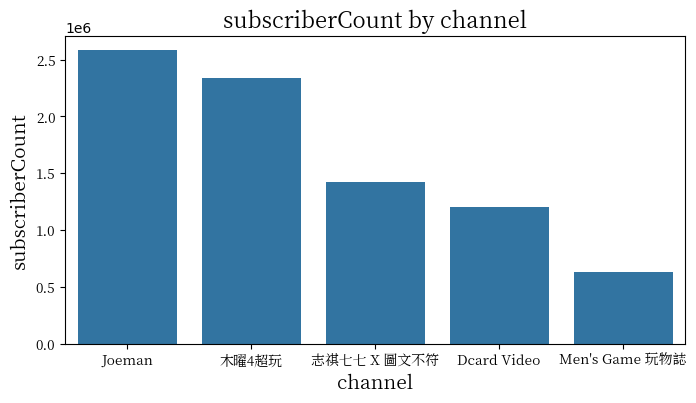

In [ ]:
from matplotlib.font_manager import FontProperties

# 設置圖形顯示風格
#plt.style.use('ggplot')   # 'default'

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小
plt.figure(figsize=(8,4))

# 繪圖
data = channel_df.sort_values(by='subscriberCount', ascending=False)
sns.barplot(data, x='channel_title', y='subscriberCount', estimator='sum', errorbar=None)
#data.plot(kind='bar', x='channel_title', y='subscriberCount', figsize=(8,4), rot=0)

# 設定圖標題，軸標籤，字型及刻度
plt.title('subscriberCount by channel', fontproperties=font, fontsize=16)
plt.xlabel('channel', fontproperties=font, fontsize=14)
plt.ylabel('subscriberCount', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font, rotation=0, fontsize=10)   # 設置 x 軸刻度
plt.yticks(fontproperties=font, rotation=0, fontsize=10)   # 設置 y 軸刻度

# 顯示圖例
#plt.legend(prop=font)

# 顯示圖片
plt.show()

#### 多圖

<ipython-input-181-db031b1db692>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)  # 設置 x 軸刻度


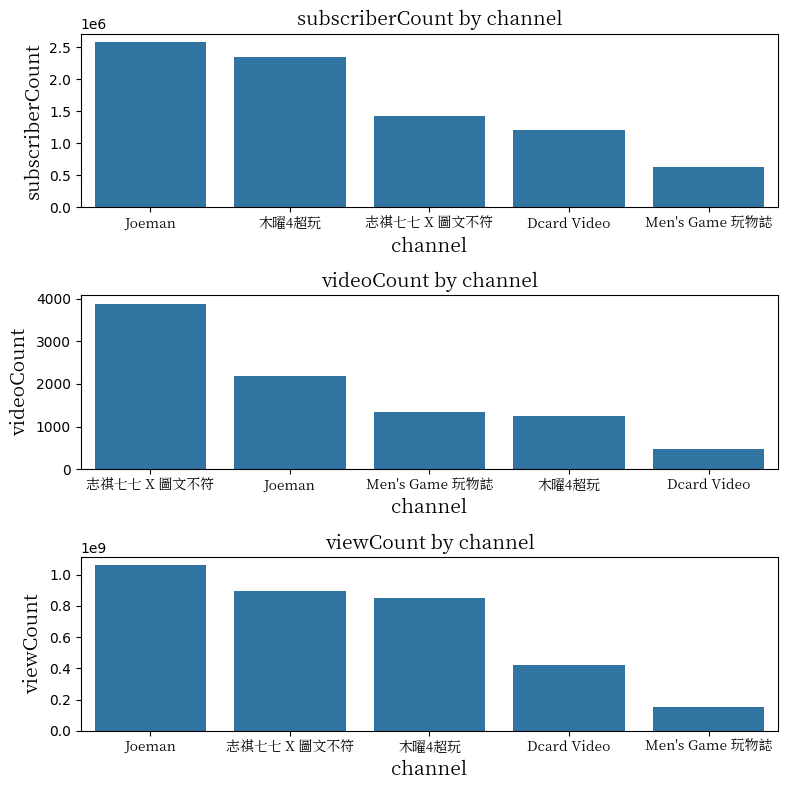

In [ ]:
from matplotlib.font_manager import FontProperties

# 設置圖形顯示風格
#plt.style.use('ggplot')   # 'default'

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

# 繪圖及設定圖標題，軸標籤，字型及刻度
data = channel_df.sort_values(by='subscriberCount', ascending=False)
sns.barplot(data, x='channel_title', y='subscriberCount', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('subscriberCount by channel', fontproperties=font, fontsize=14)
axs[0].set_ylabel('subscriberCount', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='videoCount', ascending=False)
sns.barplot(data, x='channel_title', y='videoCount', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('videoCount by channel', fontproperties=font, fontsize=14)
axs[1].set_ylabel('videoCount', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='viewCount', ascending=False)
sns.barplot(data, x='channel_title', y='viewCount', estimator='sum', errorbar=None, ax=axs[2])
axs[2].set_title('viewCount by channel', fontproperties=font, fontsize=14)
axs[2].set_ylabel('viewCount', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('channel', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)  # 設置 x 軸刻度
  #ax.legend(prop=font)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 顯示圖片
plt.show()

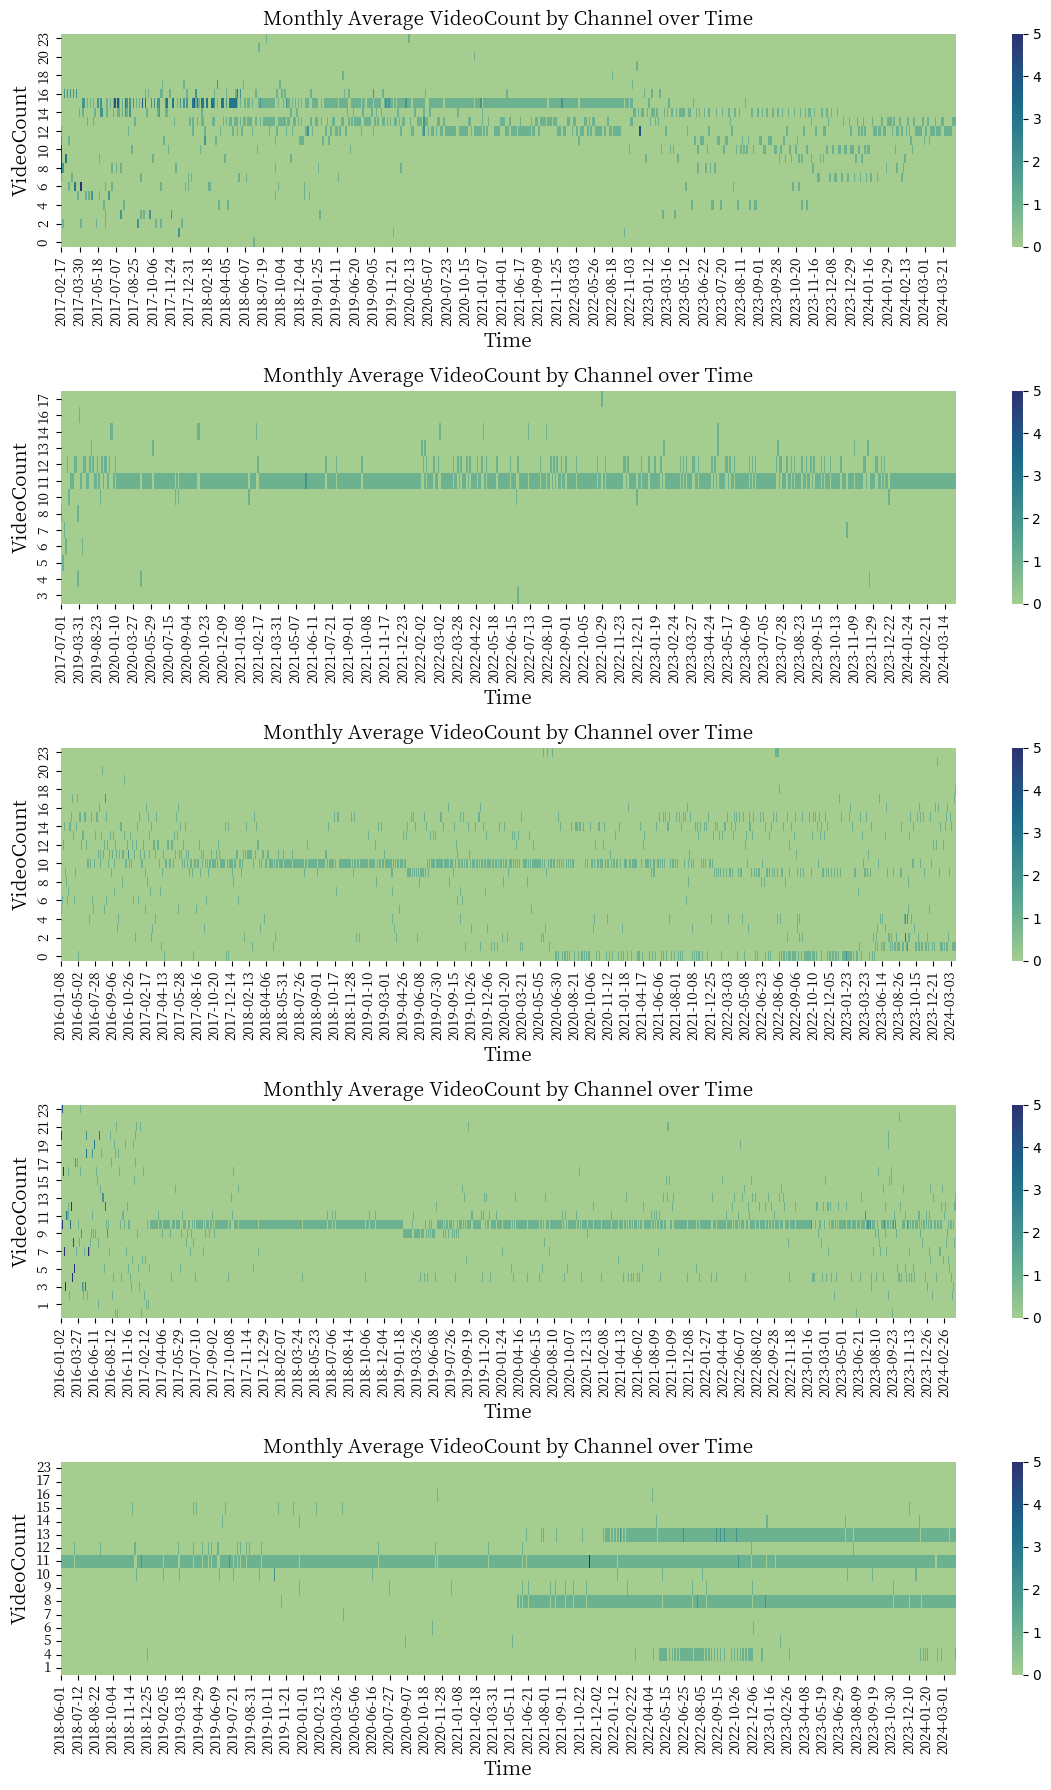

In [ ]:
from matplotlib.font_manager import FontProperties

# 創建新欄位
video_df['published_date'] = video_df['published_at'].dt.date
video_df['published_at(hr)'] = video_df['published_at'].dt.hour

# 計算各個發布時間(Date-Hour)的影片數
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
published_videoCount = data.groupby(['channel_title', 'published_date', 'published_at(hr)'])['video_id'].count().reset_index().rename(columns = {'video_id': 'videoCount'})


# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))

# 繪圖及設定圖標題，軸標籤，字型，刻度及圖例
data = published_videoCount[published_videoCount['channel_title']=='木曜4超玩'].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
data = data.reindex(index=data.index[::-1])   # 將 Y 軸倒序
sns.heatmap(data, cmap="crest", vmax=5, ax=axs[0])   # 其他參數：annot, fmt, linewidth, vmin
axs[0].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[0].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = published_videoCount[published_videoCount['channel_title']=='Dcard Video'].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, cmap="crest", vmax=5, ax=axs[1])
axs[1].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[1].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = published_videoCount[published_videoCount['channel_title']=="Men's Game 玩物誌"].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, cmap="crest", vmax=5, ax=axs[2])
axs[2].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[2].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = published_videoCount[published_videoCount['channel_title']=='Joeman'].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, cmap="crest", vmax=5, ax=axs[3])
axs[3].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[3].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = published_videoCount[published_videoCount['channel_title']=='志祺七七 X 圖文不符'].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
data = data.reindex(index=data.index[::-1])
sns.heatmap(data, cmap="crest", vmax=5, ax=axs[4])
axs[4].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[4].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Time', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=90, fontsize=10)
  ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font, fontsize=10)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 顯示圖片
plt.show()

### 頻道訂閱數，影片數，觀看數

資料期間：由頻道成立起至2024年4月27日

按頻道成立時間先後排序為：Men's Game 玩物誌（2007年），Joeman（2010年），Dcard Video（2016年），木曜4超玩（2017年），志祺七七X圖文不符（2018年）

概覽頻道的幾個總體指標（以下指標皆由大至小排序，數字為約略數）：
* 訂閱數：Joeman（258萬），木曜4超玩（234萬），志祺七七X圖文不符（142萬），Dcard Video（120萬），Men's Game 玩物誌（63萬）
* 影片數：志祺七七X圖文不符（3,891支），Joeman（2,193支），Men's Game 玩物誌（1,353支），木曜4超玩（1252支），Dcard Video（476支）
* 觀看數：Joeman（10億6千萬次），志祺七七X圖文不符（8億9千萬次），木曜4超玩（8億4千萬次），Dcard Video（4億2千萬次），Men's Game 玩物誌（1億5千萬次）

這邊發現 "志祺七七X圖文不符" 頻道最晚成立，然而可能因發布影片數最多，使得訂閱數位居第3，觀看數位居第2。

<ipython-input-15-325cb49bbe21>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


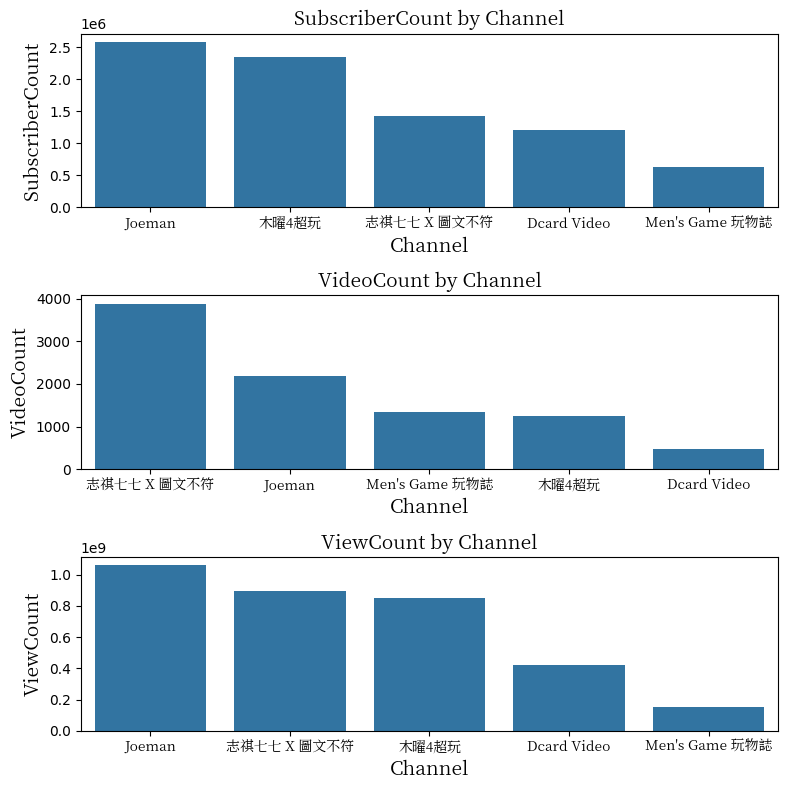

In [ ]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

# 繪圖及設定圖標題，軸標籤，字型及刻度
data = channel_df.sort_values(by='subscriberCount', ascending=False)
sns.barplot(data, x='channel_title', y='subscriberCount', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('SubscriberCount by Channel', fontproperties=font, fontsize=14)
axs[0].set_ylabel('SubscriberCount', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='videoCount', ascending=False)
sns.barplot(data, x='channel_title', y='videoCount', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('VideoCount by Channel', fontproperties=font, fontsize=14)
axs[1].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='viewCount', ascending=False)
sns.barplot(data, x='channel_title', y='viewCount', estimator='sum', errorbar=None, ax=axs[2])
axs[2].set_title('ViewCount by Channel', fontproperties=font, fontsize=14)
axs[2].set_ylabel('ViewCount', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Channel', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 顯示圖片
plt.show()

### 每月平均觀看數
說明1：若分析每日平均觀看，會使得圖形擠在一起，造成趨勢變化觀察不易。<br>
說明2：因為無法取得影片隨時間演進的觀看數變化，因此我們假設每支影片的觀看數的主要貢獻是集中在影片上傳後的一個月內，以方便了解觀看數的變化趨勢

In [ ]:
# 提取年份和月份並組成新的欄位 'published_year_month'
year_month_df = pd.DataFrame()
year_month_df['year'] = video_df['published_at'].dt.year
year_month_df['month'] = video_df['published_at'].dt.month
video_df['published_year_month'] = pd.to_datetime(year_month_df[['year', 'month']].assign(DAY=1))   # df.assign() -> Assign new columns to a DataFrame.
video_df['published_year_month']

0       2024-03-01
1       2024-03-01
2       2024-03-01
3       2024-03-01
4       2024-03-01
           ...    
10483   2018-06-01
10484   2018-06-01
10485   2018-06-01
10486   2018-06-01
10487   2018-06-01
Name: published_year_month, Length: 10488, dtype: datetime64[ns]

##### 資料期間：由頻道成立起至2024年4月27日

圖中可發現2016年以前僅有兩個頻道存在，且觀看數變化不大，因此後續主要針對2016年以後的資料進行分析

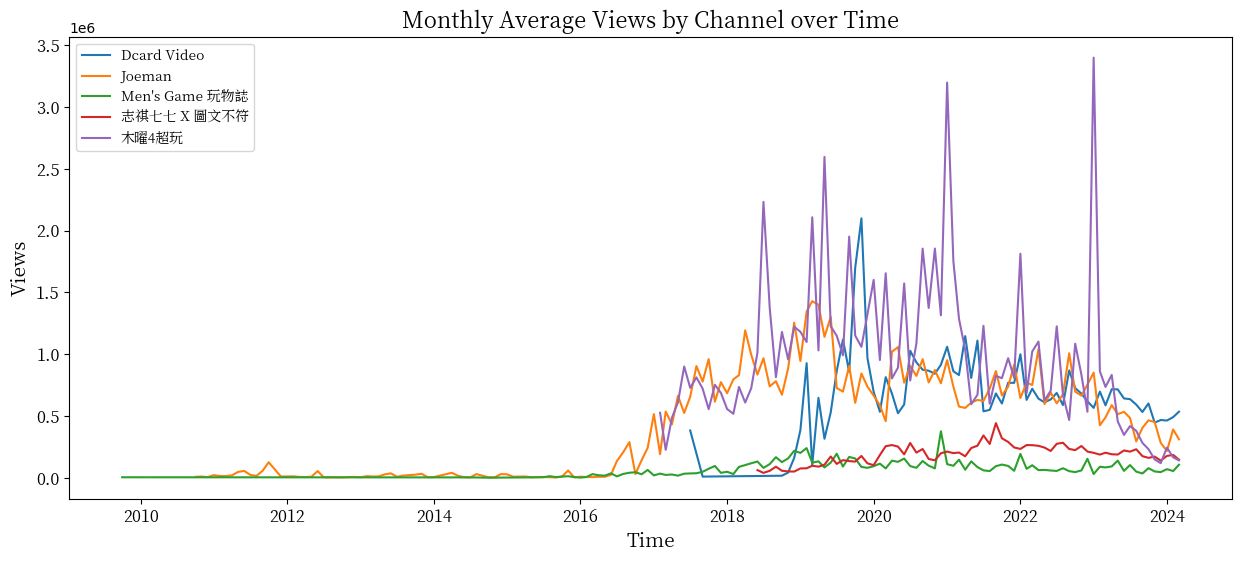

In [ ]:
# X軸的變數如果是datetime格式，它會依照時間自動排序；若不是的話，則需先自己把變數依照時間做排序再製圖
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小
plt.figure(figsize=(15,6))

# 繪圖
data = video_df.groupby(['channel_title', 'published_year_month'])['view_count'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='view_count', hue='channel_title', estimator='sum', errorbar=None)

# 設定圖標題，軸標籤，字型及刻度
plt.title('Monthly Average Views by Channel over Time', fontproperties=font, fontsize=16)
plt.xlabel('Time', fontproperties=font, fontsize=14)
plt.ylabel('Views', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font, rotation=0, fontsize=12)
plt.yticks(fontproperties=font, rotation=0, fontsize=12)

# 設定圖例
plt.legend(prop=font)

# 顯示圖片
plt.show()

##### 資料期間：2016年1月1日至2024年4月27日

觀察每月平均觀看：
* "木曜4超玩" 約落在100萬
* "Joeman" 及 "Dcard Video" 約落在50萬至100萬
* "志祺七七X圖文不符" 及 "Men's Game 玩物誌" 約落在50萬以下

2023年以後，多數頻道的觀看數皆呈現下降趨勢，可能原因為近年自媒體時代使得Youtube平台的越趨競爭，而導致流量紅利逐漸變小。

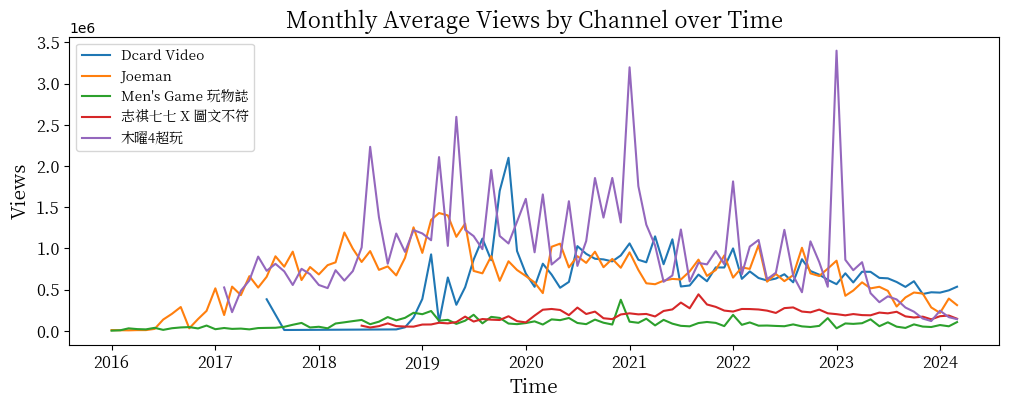

In [ ]:
# X軸的變數如果是datetime格式，它會依照時間自動排序；若不是的話，則需先自己把變數依照時間做排序再製圖
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小
plt.figure(figsize=(12,4))

# 繪圖
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['view_count'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='view_count', hue='channel_title', estimator='sum', errorbar=None)   # style="channel_title", markers=True

# 設定圖標題，軸標籤，字型及刻度
plt.title('Monthly Average Views by Channel over Time', fontproperties=font, fontsize=16)
plt.xlabel('Time', fontproperties=font, fontsize=14)
plt.ylabel('Views', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font, rotation=0, fontsize=12)
plt.yticks(fontproperties=font, rotation=0, fontsize=12)

# 設定圖例
plt.legend(prop=font)

# 顯示圖片
plt.show()

### 觀眾互動程度
想了解"影片得到觀眾按讚的比率"及"影片得到觀眾留言的比率"，以了解不同頻道下，觀眾與頻道主的互動程度。

創建欄位：
* like_per_view(%)：Number of Likes / Number of Views * 100
* comment_per_view(%)：Number of Comments / Number of Views * 100

In [ ]:
# 創建新欄位
video_df['like_per_view(%)'] = video_df['like_count']/video_df['view_count']*100
video_df['comment_per_view(%)'] = video_df['comment_count']/video_df['view_count']*100

資料期間：2016年1月1日至2024年4月27日

觀察每月平均按讚比例及留言比例：
* "志祺七七X圖文不符" 相較其他4個頻道的按讚比例明顯較高，且隨時間呈上升趨勢；而留言比例亦相較其他4個頻道來得高，但隨時間呈下降趨勢。細部查看發現該頻道一開始是每月上傳約30支影片，自2021年5月開始錄製短影音shorts而提升到每月約60支影片，自2022年1月以後則提升到90支，可能為造成按讚比例及留言比例有明顯變化的原因，說明短影音可能更容易取得讚數，但較不會獲得觀眾留言

<ipython-input-20-76f3e4981298>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


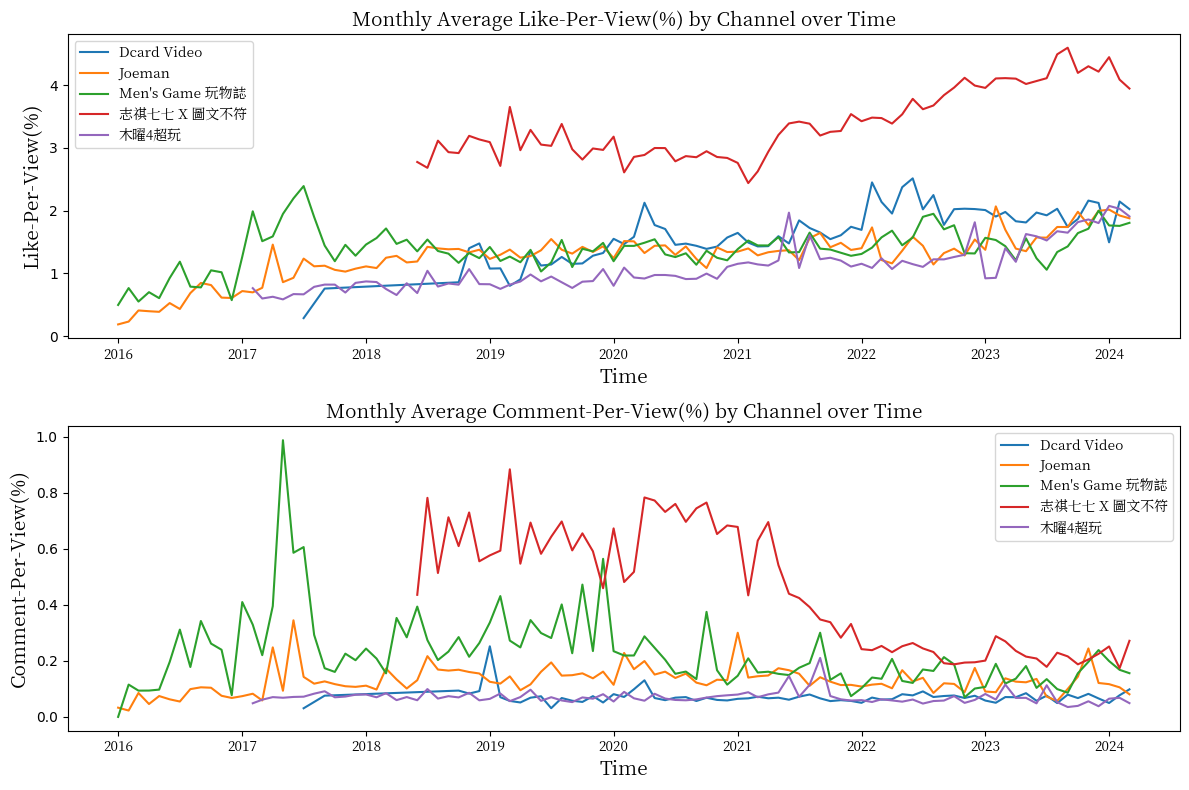

In [ ]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# 繪圖及設定圖標題，軸標籤，字型，刻度及圖例
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['like_per_view(%)'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='like_per_view(%)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[0])   # style="channel_title", markers=True
axs[0].set_title('Monthly Average Like-Per-View(%) by Channel over Time', fontproperties=font, fontsize=14)
axs[0].set_ylabel('Like-Per-View(%)', fontproperties=font, fontsize=14)

data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['comment_per_view(%)'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='comment_per_view(%)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[1])   # style="channel_title", markers=True
axs[1].set_title('Monthly Average Comment-Per-View(%) by Channel over Time', fontproperties=font, fontsize=14)
axs[1].set_ylabel('Comment-Per-View(%)', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Time', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)
  #ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font, rotation=0, fontsize=10)
  ax.legend(prop=font)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 顯示圖片
plt.show()

In [ ]:
# 查看影片時間小於2分鐘及超過2分鐘，分別在按讚比例及留言比例上的差別

shorter = video_df[video_df['video_duration_minutes']<=2][["like_per_view(%)", "comment_per_view(%)"]].mean()
print(f"【影片時間小於2分鐘】\n{shorter}\n")
longer = video_df[video_df['video_duration_minutes']>2][["like_per_view(%)", "comment_per_view(%)"]].mean()
print(f"【影片時間超過2分鐘】\n{longer}")

【影片時間小於2分鐘】
like_per_view(%)       3.949954
comment_per_view(%)    0.139125
dtype: float64

【影片時間超過2分鐘】
like_per_view(%)       1.523522
comment_per_view(%)    0.252191
dtype: float64


### 每月平均發布影片數及影片長度

資料期間：2016年1月1日至2024年4月27日

短影片，長影片策略

In [ ]:
# 選取所需資料
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
month_average_videoCount = data.groupby(['channel_title', 'published_year_month'])['video_id'].count().reset_index().rename(columns = {'video_id': 'videoCount'})
month_average_videoDuration = data.groupby(['channel_title', 'published_year_month'])['video_duration_minutes'].mean().reset_index().rename(columns = {'video_duration_minutes': 'avg_duration(mins)'})

<ipython-input-23-08ef1d243d8d>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


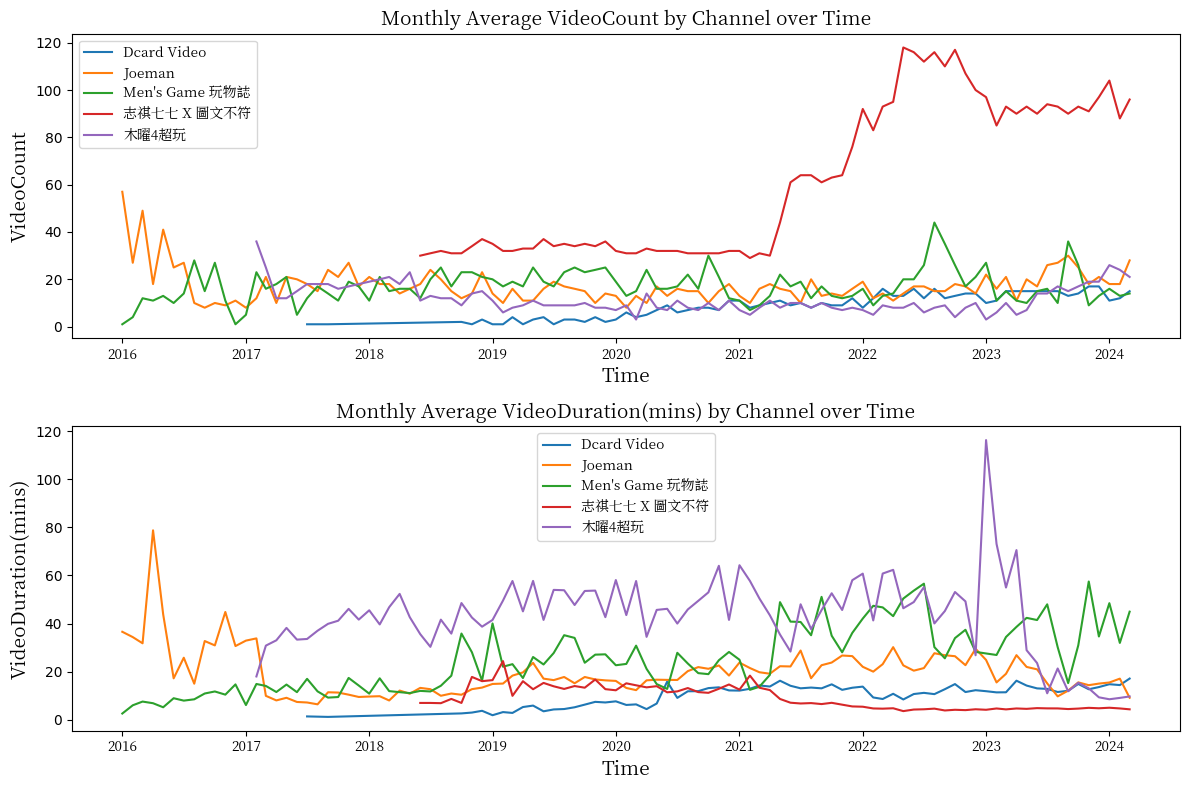

In [ ]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# 繪圖及設定圖標題，軸標籤，字型，刻度及圖例
sns.lineplot(month_average_videoCount, x='published_year_month', y='videoCount', hue='channel_title', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('Monthly Average VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[0].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

sns.lineplot(month_average_videoDuration, x='published_year_month', y='avg_duration(mins)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('Monthly Average VideoDuration(mins) by Channel over Time', fontproperties=font, fontsize=14)
axs[1].set_ylabel('VideoDuration(mins)', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Time', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)
  #ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font, rotation=0, fontsize=10)
  ax.legend(prop=font)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 顯示圖片
plt.show()

### 影片發布時間

In [ ]:
# 創建新欄位
video_df['published_date'] = video_df['published_at'].dt.date
video_df['published_at(hr)'] = video_df['published_at'].dt.hour

In [ ]:
# 計算各個發布時間(Date-Hour)的影片數
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
published_videoCount = data.groupby(['channel_title', 'published_date', 'published_at(hr)'])['video_id'].count().reset_index().rename(columns = {'video_id': 'videoCount'})

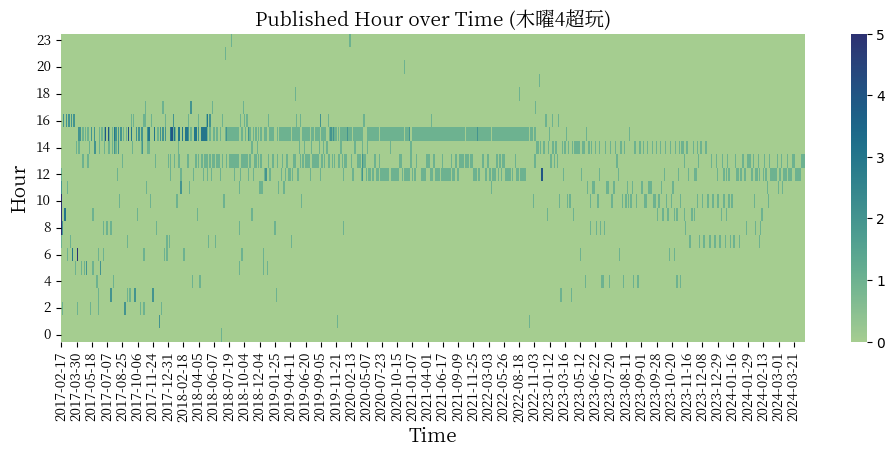

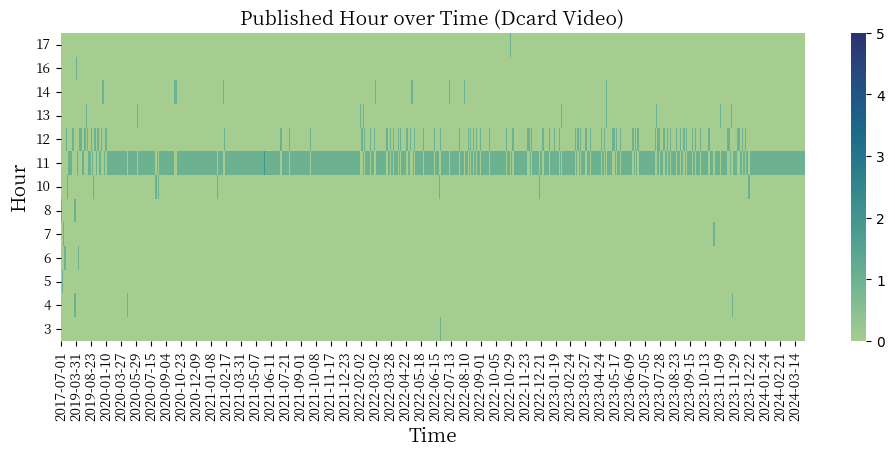

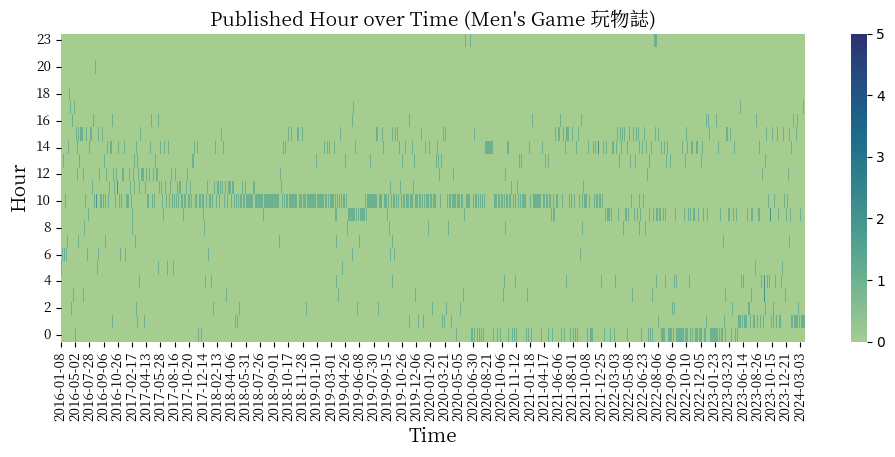

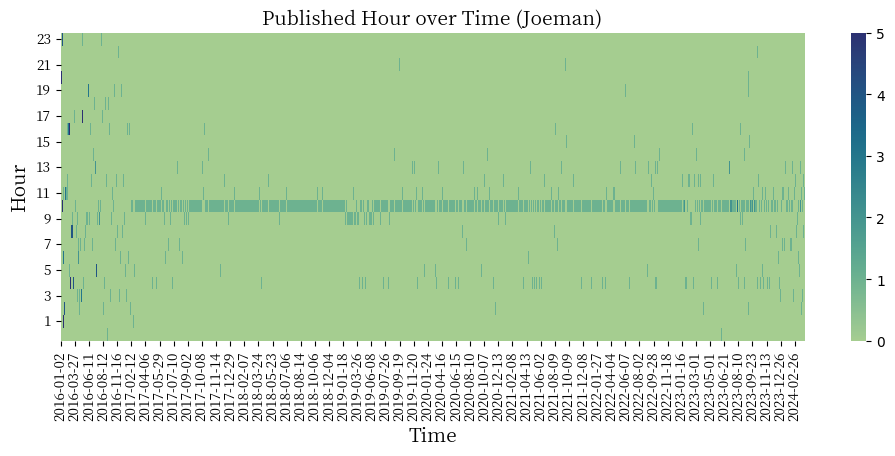

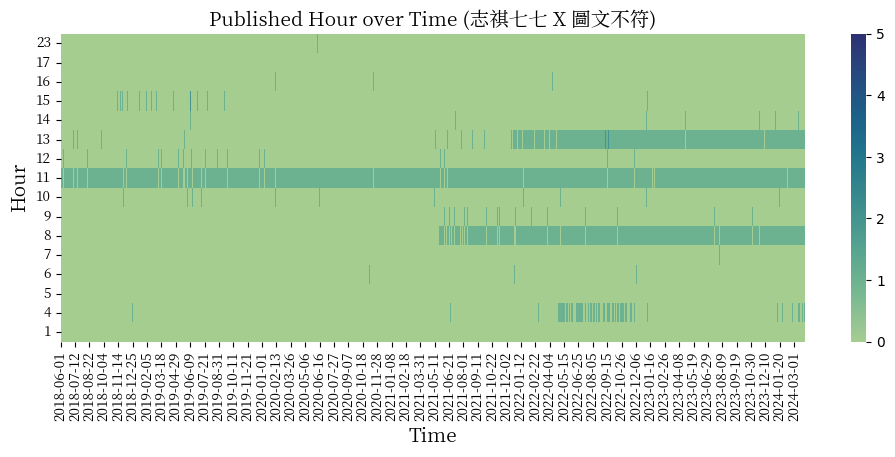

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

def make_heatmap(data, channel_title):
  # 設定figure大小
  plt.figure(figsize=(12,4))

  # 繪圖
  data = data[data['channel_title']==channel_title].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
  data = data.reindex(index=data.index[::-1])   # 將 Y 軸倒序
  sns.heatmap(data, cmap="crest", vmax=5)   # 其他參數：annot, fmt, linewidth, vmin

  # 設定圖標題，軸標籤，字型及刻度
  plt.title(f"Published Hour over Time ({channel_title})", fontproperties=font, fontsize=14)
  plt.xlabel('Time', fontproperties=font, fontsize=14)
  plt.ylabel('Hour', fontproperties=font, fontsize=14)
  plt.xticks(fontproperties=font, rotation=90, fontsize=10)
  plt.yticks(fontproperties=font, rotation=0, fontsize=10)

  # 顯示圖片
  plt.show()

channel_titles = ['木曜4超玩', 'Dcard Video', "Men's Game 玩物誌", 'Joeman', '志祺七七 X 圖文不符']
for channel_title in channel_titles:
  make_heatmap(published_videoCount, channel_title)


### 影片最常設定的標籤（Tags）

In [ ]:
# 創建新欄位
video_df['published_year'] = video_df['published_at'].dt.year

In [ ]:
import ast
import numpy as np

# 定義一個函數來安全地應用 ast.literal_eval
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (SyntaxError, ValueError):
        return np.nan  # 如果解析失敗，返回 NaN

# 去除video_tags欄位的字串，取得裡面的列表
video_df['tags'] = video_df['video_tags'].apply(safe_literal_eval)

In [ ]:
def most_used_tags_by_year(data, channel_title, n_tags):
  # 選取所需資料，並將tags欄位中每列的列表拆開變成多列
  selected = data[(data['channel_title'] == channel_title)]
  all_tags = selected.explode('tags').groupby(['published_year', 'tags']).size().reset_index(name='tag_count')
  all_tags = all_tags[all_tags['tags']!='yt:cc=on'].reset_index(drop=True)   # 排除特定tag

  # 找出每個年份下，前n名使用數的tags
  top_tags = all_tags.groupby('published_year').apply(lambda x: x.nlargest(n_tags, 'tag_count')).reset_index(drop=True)

  # 將資料轉換成pivot table
  pivot_table = top_tags.pivot_table(index=top_tags.groupby('published_year').cumcount()+1, columns='published_year', values='tags', aggfunc='first')   # groupby.cumcount -> 會從0計數

  print(f"Top {n_tags} Tags by Year ({channel_title})")
  return pivot_table

In [ ]:
# 列出每個頻道前n名使用數的tags
channel_titles = ['木曜4超玩', 'Dcard Video', "Men's Game 玩物誌", 'Joeman', '志祺七七 X 圖文不符']
for channel_title in channel_titles:
  display(most_used_tags_by_year(video_df, channel_title, n_tags = 5))
  print('\n')

Top 5 Tags by Year (木曜4超玩)


published_year,2017,2018,2019,2020,2021,2022,2023,2024
1,邰智源,一日系列,一日系列,energy,energy,energy,energy,energy
2,泱泱,木曜4超玩,木曜4超玩,一日系列,一日系列,一日系列,一日系列,一日系列
3,溫妮,泱泱,泱泱,坤達,坤達,坤達,坤達,上班去吃飯
4,木曜4超玩,溫妮,溫妮,木曜4超玩,小黑,小黑,木曜4超玩,下班去吃飯
5,一日系列,綜藝節目,邰智源,泱泱,木曜4超玩,木曜4超玩,木耀,丘涵




Top 5 Tags by Year (Dcard Video)


published_year,2017,2018,2019,2020,2021,2022,2023,2024
1,DCARD,dcard,街訪,Dcard,Dcard,Dcard,Dcard,IG
2,一年,Dcard,校訪,Dcard調查局,Dcard調查局,dcard,文章,女生
3,女孩,D雞精新聞,dcard,街訪,Dcard尋奇,街訪,精選,男生
4,牙齒矯正,dcard調查局,Dcard,校訪,低卡,Dcard調查局,尋奇,社群
5,秘密,公益,dcard調查局,Dcard尋奇,感情,低卡,街訪,CK




Top 5 Tags by Year (Men's Game 玩物誌)


published_year,2009,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1,ANA飛機併飛,wilier,rx100m4,dji,dji,game,game,game,game,game,game,game
2,NaN,roadbike,sony,drone,mavic,men's,men's,men's,men's,men's,men's,men's
3,NaN,公路車,fdrax100,phantom,roadbike,iphone,iphone,iphone,Three Kingdom Tactics,S4,Joeman,日本
4,NaN,18禁,roadbike,roadbike,phantom,apple,apple,apple,三国志战略版,Three Kingdom Tactics,養老,買房
5,NaN,GoPro,公路車,gopro,youtuber,review,台灣人行大陸,手機,開箱,三国志战略版,10萬,3Ctim




Top 5 Tags by Year (Joeman)


published_year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1,RP,joeman,justin.tv,joeman,joeman,joeman,dota,joeman,MAZDA,BMW,BMW,BMW,BMW,BMW,BMW
2,RTS,starcraft,joeman,justin.tv,羅密歐,攻略,joeman,九妹,joeman,MAZDA,MAZDA,MAZDA,SUV,MAZDA,MAZDA
3,joeman,星海爭霸,starcraft,twitch,JOEMAN,刀塔傳奇,legend,實況,九妹,SUV,SUV,SUV,TOYOTA,SUV,SUV
4,starcraft,RTS,joemanstarcraft,明星,暴雪英霸,秘技,starcraft,搞笑,實況,TOYOTA,TOYOTA,TOYOTA,joeman,TOYOTA,TOYOTA
5,starcraft2,RP,gaming,海峽,刀塔傳奇,實況,talk,直播,德國,joeman,joeman,joeman,lifestyle,joeman,joeman




Top 5 Tags by Year (志祺七七 X 圖文不符)


published_year,2018,2019,2020,2021,2022,2023,2024
1,圖文不符,志祺七七,武漢肺炎,中國,中國,中國,日本
2,志祺,張志祺,新聞回顧,日本,日本,日本,中國
3,志祺七七,志祺,國際新聞,美國,疫情,世界紀錄,211餐盤
4,時事,圖文不符,台灣新聞,台灣,美國,獵奇,外食族
5,知識,時事,韓國瑜,奧運,烏俄戰爭,美國,外食減重學


### 觀看數最多的影片標題

In [ ]:
# 篩選出每個頻道前n名觀看數的影片
top_videos = video_df[['channel_title', 'video_title', 'view_count']].\
          sort_values(by=['channel_title', 'view_count'], ascending=[True, False]).\
          groupby('channel_title').head(10)

# 調整呈現方式
pivot_df = top_videos.set_index(['channel_title', top_videos.groupby('channel_title').cumcount()+1]).unstack(level=0)   # groupby.cumcount -> 會從0計數 ； df.unstack 類似 df.pivot_table
pivot_df

video_title  \
channel_title                                        Dcard Video   
1              明星喬裝潛入校園會被發現嗎？【音癡 vs 天籟美聲頂尖對決！】特別企劃 Feat.🎤神隱少女...   
2              30歲存不到10萬可以嗎？年輕人VS長輩看法交鋒！理財已經退流行了，散財才是正解？【30歲存...   
3              8+9女友都好正，原來是夠壞夠有錢？沒有很可以，但你惹不起！【 校園8+9大搜查！】致理科技...   
4              幫扣安全帽、約看螢火蟲、喝醉時送上膝枕！受訪者現場的曖昧直球～調查局這次要當媒人了！？【曖昧...   
5              暈船花了三年才戒掉？頻繁私訊、各種親密接觸！來看看暈船仔是如何被養套殺！【 暈船患者集中營】...   
6              (ENG / 한글자막 SUB )巧遇舒華啊啊啊｜愛追星的女友｜如何取綽號 @officia...   
7                            買鞋買到20萬？一餐只花35塊？【敗家VS節儉大對決】台北商業大學校訪   
8              抖M男興起！女生講髒話、開黃腔也可以很加分？【理想女友大公開】台灣海洋大學校訪 | Dcar...   
9                          【有錢人 VS 平民大對決！】 I 信義區街訪 I Dcard 調查局 🧐   
10                           最花心的星座是前男友？星座運勢只挑好的看？【星座刻板印象】桃園銘傳校訪   

                                                                  \
channel_title                                             Joeman   
1               【Joeman Show Ep18】獨家揭密！老高與小茉的愛情故事！ft.老高 Kuaizero   
2                            【Joeman Show Ep29】史上最貴！開箱台灣首富郭台銘的家！   
3                              【Joeman】如果人生24小時都被17直播監視！？(ft.咪妃)   
4                 【Joeman Show Ep4】矛盾對決！吃不飽的大胃王vs吃到飽的高級牛排店！ft.路路   
5              【Joeman】1000元的頂級便當對決50元的平價便當！ft.柯文哲【Joe是要對決】SP...   
6                                【Joeman】長榮皇璽桂冠艙體驗！在飛機上吃龍蝦！(商務艙)   
7                  【Joeman】開價兩億的新莊豪宅！貧窮限制我的想像！遠雄九五《Joe是要看房》 ep.3   
8              【Joeman】直逼頭等艙的豪華配置！大韓航空商務艙體驗！Korean Air A380 B...   
9                                  【Joeman】實測！網路上徵打字賺外快的廣告原來是詐騙？   
10             【Joeman】在飛機上吃鴨胸！華航A350-900商務艙體驗！China Airlines...   

                                                                  \
channel_title                                     Men's Game 玩物誌   
1              體驗火龍功直接用火燒 沐雨柔 @evemu716 的背 火療福利時間 「Men's Game...   
2              [ENG Sub]全是假貨？蘋果Apple iPhone 山寨大本營 Airpods好便宜 ...   
3              這樣子住更便宜！ 大草皮 組合屋vs  貨櫃屋 竟然比我家還要高級 不買房EP05「Men'...   
4              [ ENG Sub ] 我不用iPhone了 這 N 個理由告訴你為什麼我叛逃到androi...   
5                不孝？你能接受送父母親去養老院嗎？體驗養老生活 ft.長庚養生村「Men's Game玩物誌」   
6              被吃軟飯老公推入當酒店小姐！後來如何脫離酒店轉戰YouTube ? 今天誰上車EP04 @e...   
7              開箱華強北山寨 AirPods vs 原廠正品 誰比較強大？假貨真貨怎麼分？耳機iPhone...   
8                     開飲料店能賺錢嗎？ 不是客人越多越賺錢！「Men's Game玩物誌」#shorts   
9              防疫自己用電動理髮器推頭髮很省錢 | 油頭髮型必備 | 德國百靈BRAUN HC5030電動...   
10             會黃標啦！怕癢的不要來 腳底按摩按起來 看美腿的都去罰站啦 ft.沐雨柔 愛美教主 @eve...   

                                                                  \
channel_title                                        志祺七七 X 圖文不符   
1                 🇨🇳中國外交部發言人＃趙立堅 出包辱華！原因竟然是......？😅｜志祺七七 #shorts   
2                        🎤 中共百年生日，習近平：中國沒有欺壓過別人！💢｜志祺七七   #shorts   
3                🤦🏻‍♂️現代版「大意失荊州」！中國斥資上億的 #關公銅像 遭拆除🪓｜志祺七七 #shorts   
4                            日本餐廳拒接中國客😲祭出「64符咒」超有用😲｜志祺七七 #shorts   
5                           奧運網球女雙落敗，台灣觀眾還嘲笑狂酸？「詹家姐妹」為何被討厭？｜志祺七七   
6                           外國玩家改裝「金正恩痛車」，結果竟然慘遭⋯⋯！｜志祺七七 #shorts   
7              你知道這是什麼嗎？ 亞馬遜電商Ellen到底是誰？這真的是詐騙嗎？《YouTube 觀察日記...   
8                             🇹🇼中國＝西台灣？這麼直接辱華真的好嗎？！｜志祺七七 #shorts   
9              【 志祺七七 】《逃犯條例》到底有多可怕？為何讓百萬香港人不顧一切也要上街阻擋？《左邊鄰居觀...   
10                           🎊太神啦！北市小四學生，讓全校不用寫作業！👏｜志祺七七 #shorts   

                                                                  view_count  \
channel_title                                              木曜4超玩 Dcard Video   
1              《一日系列第六十九集》最強主管～市長柯P來了！邰哥來挑戰史上最崩潰工作！-一日市長幕僚fea...     3308830   
2              2020第二屆YARTIST全明星運動大會!新世代-集結!團結就是力量!Ft.這群人.千千....     3030908   
3              《一日系列第一百集》喜鴻假期來了!!邰導遊帶木曜全體工作人員暢玩北海道!!-一日北海道導遊(...     2921581   
4              2021第三屆YARTIST全明星運動大會-無論輸贏！拚盡全力！Ft.這群人.視網膜.眼肉芽...     2578762   
5              2019第一屆YARTIST全明星運動大會!!全部人都給我動起來!! Feat.白癡公主.阿...     2337082   
6              2022第四屆YARTIST全明星運動大會-突破逆境！飛越稜線！Ft.Fischer's這群...     2327431   
7              《木曜家民宿3-宜蘭篇(上)》我誰!!!狠愛演帶著六萬人團隊來入住木曜家民宿啦!!〔一日系列...     2288197   
8              你說什麼廠商？！這次濃縮再濃縮，實境再實境！feat.蔡哥、泡泡、蟲蟲學姊【一個屋簷下】(新... 

### 影片標題及影片說明的字數 & 標籤使用數量

In [ ]:
# 創建新欄位
video_df['video_title_length'] = video_df['video_title'].apply(lambda x: len(x))
video_df['video_description_length'] = video_df['video_description'].apply(lambda x: len(x) if not pd.isna([x]).all() else 0)   # pd.isna([]) 很好用
video_df['tags_count'] = video_df['tags'].apply(lambda x: len(x) if not pd.isna([x]).all() else 0)   # pd.isna([]) 很好用

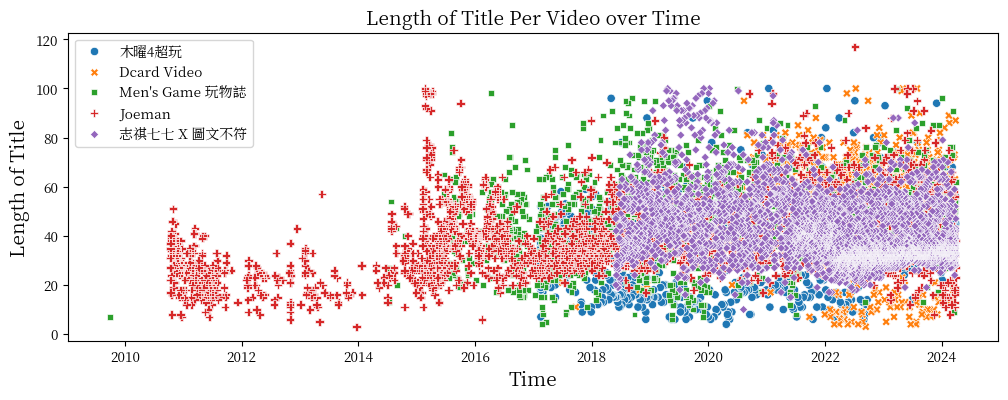

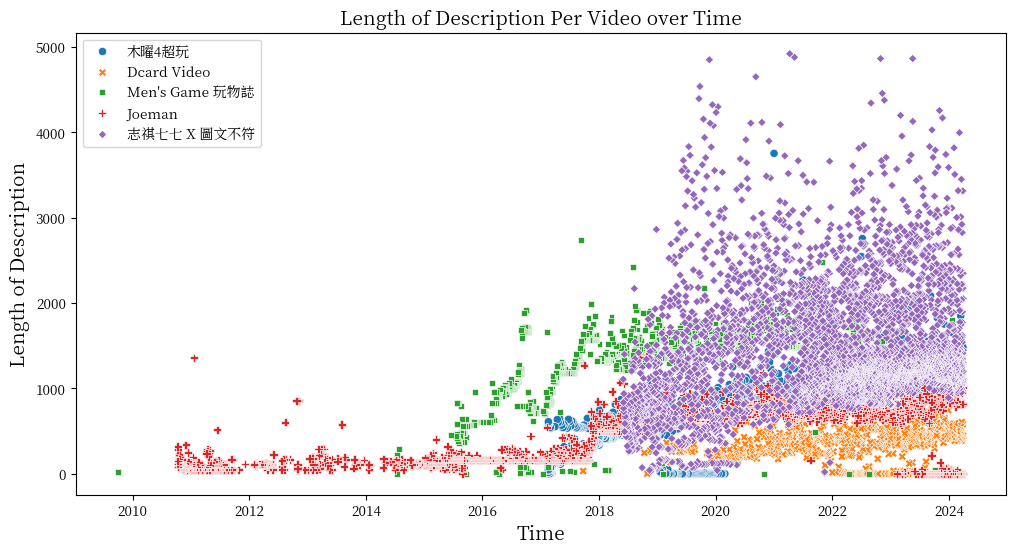

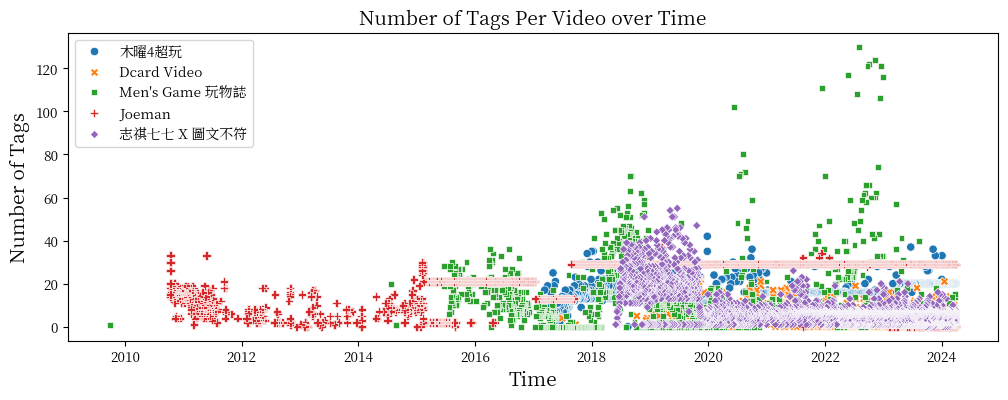

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

def make_scatter(data, feature, figsize, plt_title, plt_ylabel):
  # 設定figure大小
  plt.figure(figsize=figsize)

  # 繪圖
  sns.scatterplot(video_df, x='published_date', y=feature, hue='channel_title', style="channel_title")
  #sns.relplot(video_df, x="published_date", y="tags_count", col="channel_title", col_wrap=2, kind="scatter")  # 其他參數：hue, style, row

  # 設定圖標題，軸標籤，字型及刻度
  plt.title(plt_title, fontproperties=font, fontsize=14)
  plt.xlabel('Time', fontproperties=font, fontsize=14)
  plt.ylabel(plt_ylabel, fontproperties=font, fontsize=14)
  plt.xticks(fontproperties=font, rotation=0, fontsize=10)
  plt.yticks(fontproperties=font, rotation=0, fontsize=10)

  # 設定圖例
  plt.legend(prop=font)

  # 顯示圖片
  plt.show()

features = ['video_title_length', 'video_description_length', 'tags_count']
figsize = [(12,4), (12,6), (12,4)]
plt_titles = ["Length of Title Per Video over Time", "Length of Description Per Video over Time", "Number of Tags Per Video over Time"]
plt_ylabels = ["Length of Title", "Length of Description", "Number of Tags"]
for ind, feature in enumerate(features):
  make_scatter(video_df, feature, figsize[ind], plt_titles[ind], plt_ylabels[ind])


## 參考資料
* [APIs For Beginners - YouTube API Example](https://www.youtube.com/watch?v=OLW6s_uAoc4)
* [新創如何與 YouTuber 合作，借助他們的影響力](https://appworks.tw/startup-youtuber-marketing/)
* [YouTube Data API (v3) - Quota Calculator](https://developers.google.com/youtube/v3/determine_quota_cost)
* [如何提升 YouTube 點閱率？YouTube 標籤是什麼？為什麼很重要？](https://tw.cyberlink.com/blog/youtube-video-editing/543/youtube-seo)